Below algorithm uses method proposed by Har-Peled (https://graphics.stanford.edu/courses/cs468-06-fall/Papers/07%20har-peled%20-%20focs%202001.pdf)

In [5]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import sys
sys.path.append(r'\Users\Mochi\AppData\Local\Programs\Python\Python310\Lib\site-packages')
import quads
import numpy as np
from sklearn.cluster import KMeans
import math
import matplotlib.patches as patches
import statistics as stat

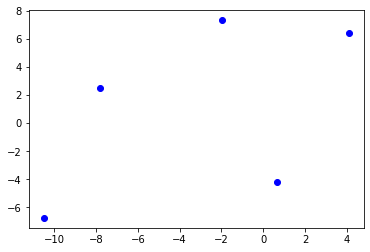

In [6]:
X, y = make_blobs(n_samples=5, centers=5, n_features=2,random_state=100)
plt.scatter(X[:,0], X[:,1], c='blue');
plt.show();

In [7]:
size = X.shape[0]
lam = 2 # lam > 0
gamma = 0.4 # gamma < 1/2

In [8]:
def distance(p1, p2, X):
    """
    if p1 != p2, then compute min distance between a point in p1 and a point in p2
    
    otherwise, compute min distance between 2 points in X
    
    *assumed no duplicates
    """
    min_D = sys.maxsize
    if p1.all() == p2.all():
        for x in range(X.shape[0]):
            for y in range(X.shape[0]):
                if not x==y:
                    min_D = min(math.dist(X[x], X[y]), min_D)
    else:
        for x in p1:
            for y in p2:
                min_D = min(math.dist(X[x], X[y]), min_D)
    return min_D

In [9]:
def divide_P(X, pairs): 
    p1 = []
    p2 = []
    if not len(pairs) == 0:
        for (u,v) in pairs:
            if not u in p1:
                p1.append(u)
            if not v in p1:
                p1.append(v)
        for x in range(len(X)):
            if not x in p1:
                p2.append(x)
    return np.array(p1), np.array(p2)

In [10]:
def compute_min_span_tree(X, lam):
    size = X.shape[0]
    mst = []
    edge = []
    while not len(mst)==size-1:
     #length should be n-1 pairs
        for u in range(size):
            if len(mst)==size-1:
                break
            for v in range(X.shape[0]):
                if not u==v and not (u,v) in mst and not (v,u) in mst:
                    len_e = math.dist(X[u], X[v])
                    p1, p2 = divide_P(X, mst)
                    if len(p1)==0:
                        dist = distance(X,X,X)
                    else:
                        dist = distance(p1, p2, X)
                    if len_e <= dist and dist <= lam*len_e:
                        mst.append((u,v))
                        edge.append(math.dist(X[u], X[v]))
                        break
    mst = np.array(mst)
    edge = np.array([edge])
    mst_with_edge = np.concatenate((mst, edge.T), axis=1)
    return mst, edge, mst_with_edge

In [11]:
mst, edge, mst_with_edge = compute_min_span_tree(X, lam)

In [15]:
mst_with_edge

array([[ 1.        ,  4.        ,  6.12457347],
       [ 0.        ,  1.        ,  7.55076122],
       [ 2.        ,  0.        ,  9.66582598],
       [ 3.        ,  0.        , 10.80980414]])

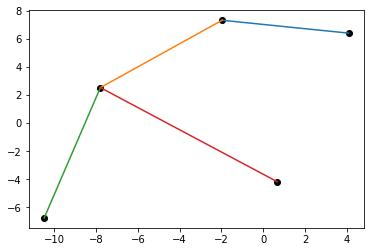

In [12]:
###plot MST
for (u,v) in mst:
    x_val = np.array([X[u][0], X[v][0]])
    y_val = np.array([X[u][1], X[v][1]])
    plt.plot(x_val, y_val)
plt.scatter(X[:,0], X[:,1], c='black');
plt.show()

In [14]:
class DirectedTree:
    def __init__(self, node_id, point):
        self.node_id = node_id
        self.point = point
        self.parent = None
        self.children = []
    def __repr__(self):
        return 'Tree {}: Point: {}, Children: {}'.format(str(self.node_id), str(self.point), str(self.children))
    def add_child(self, child):
        self.children.append(child)
    def merge_tree(self, t2, mst):
        if len(self.children) == 0 and len(t2.children) == 0:
            self_count = np.count_nonzero(mst == self.node_id)
            t2_count = np.count_nonzero(mst == t2.node_id)
            if self_count >= t2_count:
                self.add_child(t2)
                t2.parent = self
                return self, self.node_id, t2.node_id
            else:
                t2.add_child(self)
                self.parent = t2
                return t2, t2.node_id, self.node_id
        elif len(self.children) > len(t2.children):
            self.add_child(t2)
            t2.parent = self
            return self, self.node_id, t2.node_id
        else:
            t2.add_child(self)
            self.parent = t2
            return t2, t2.node_id, self.node_id

In [17]:
def get_tree(forest, idx, merge):
    for tree in forest:
        if tree.node_id == idx:
            return tree
    for (new, remove) in merge:
        if remove == idx:
            for tree in forest:
                if tree.node_id == new:
                    for c in tree.children:
                        if c.node_id == remove:
                            return c

In [18]:
def compute_directed_tree(X, mst_with_edge):
    forest = []
    for t in range(len(X)):
        forest.append(DirectedTree(t, X[t]))
    temp_mst = mst_with_edge
    temp_forest = forest
    merge_history = []
    r_loss = []
    while not len(temp_mst) == 0:
        u = temp_mst[0][0]
        v = temp_mst[0][1]
        u = get_tree(temp_forest, u, merge_history)
        v = get_tree(temp_forest, v, merge_history)
        new_tree, new_id, removed_id = DirectedTree.merge_tree(u, v, mst)
        r_loss.append([new_id, removed_id, temp_mst[0][2]/2])
        temp_mst = np.delete(temp_mst, 0, 0)
        temp_forest.remove(get_tree(temp_forest, removed_id, merge_history))
        merge_history.append((new_id, removed_id))
    return temp_forest, r_loss

In [19]:
forest, r_loss = compute_directed_tree(X, mst_with_edge)
forest

[Tree 1: Point: [-1.96767517  7.33068613], Children: [Tree 4: Point: [4.0877025  6.41264396], Children: [], Tree 0: Point: [-7.79714858  2.53159927], Children: [Tree 2: Point: [-10.48921793  -6.75177051], Children: [], Tree 3: Point: [ 0.678603   -4.17761085], Children: []]]]

In [20]:
r_loss

[[1, 4, 3.062286734295503],
 [1, 0, 3.775380608842835],
 [0, 2, 4.8329129916427425],
 [0, 3, 5.404902069403021]]

In [21]:
def reorder_rloss(r_loss, X): ##id -> r_loss
    r_loss = np.array(r_loss)
    new_r = np.zeros((X.shape[0], 1))
    for r in range(r_loss.shape[0]):
        new_r[int(r_loss[r][1])] = r_loss[r][2]
    return new_r
def compute_rdeath(r_loss, lam, gamma):
    return 6 * lam * r_loss * math.log(X.shape[0],2) * X.shape[0] / gamma
def compute_rmedian(X_rloss):
    return stat.median(X_rloss)
def compute_rtop(r_median, X, P, lam, gamma): #P entire point-set, X is subset of P
    return((36*lam*X.shape[0]*math.log(P.shape[0],2))/gamma)*r_median

In [22]:
ordered_rloss = reorder_rloss(r_loss, X)
ordered_rloss

array([[3.77538061],
       [0.        ],
       [4.83291299],
       [5.40490207],
       [3.06228673]])

In [24]:
r_death = compute_rdeath(ordered_rloss, lam, gamma)
r_death

array([[1314.92434568],
       [   0.        ],
       [1683.25146832],
       [1882.46909476],
       [1066.56144044]])

In [25]:
r_median = compute_rmedian(ordered_rloss)
r_median[0]

3.775380608842835

In [26]:
r_top = compute_rtop(r_median, X, X, lam, gamma)
r_top

array([7889.54607411])

In [27]:
class NNSearchNode:
    def __init__(self):
        # self.r_negative = None
        # self.r_positive = None
        # self.P = None
        self.outer = None
        self.inner = []
        self.IPLEB = None
    def __repr__(self):
        return 'Node -- Outer: {}, Inner: {}'.format(str(self.outer), str(self.inner))
    def add_outer(self, outer):
        self.outer = outer
    def add_inner(self, inner):
        self.inner.append(inner)
class NNSearchTree:
    def __init__(self):
        self.root = None
    def __repr__(self):
        return 'Root: {}'.format(str(self.root))
    def add_root(self, root):
        self.root = root

In [28]:
def connected_component(X, r):
    cc = []
    for x in range(X.shape[0]):
        temp = []
        temp.append(x)
        for y in range(x+1,X.shape[0]):
            if math.dist(X[x],X[y])<=2*r:
                temp.append(y) 
        cc.append(temp)
    have_duplicate = True
    while have_duplicate:
        have_duplicate = False
        for i in range(len(cc)): 
            for j in range(i+1, len(cc)):
                if len(set(cc[i]).intersection(cc[j]))>0:
                    cc[i] = list(set(cc[i]).union(cc[j]))
                    cc.pop(j)
                    have_duplicate = True
                    break
            break
    return cc

In [29]:
class IPLEB:
    def __init__(self,P,a,b,e):
        self.P = P
        self.a = a
        self.b = b
        self.e = e
class Ball:
    def __init__(self, point, rad):
        self.point = point
        self.rad = rad
    def __repr__(self):
        return 'Ball: Point: {}, Radius: {}'.format(str(self.point), str(self.rad))

In [34]:
def buildNNTree(F, M, M_rloss, M_rdeath, lam, gamma, r_min, r_max, P):
    tree = NNSearchTree()
    v = NNSearchNode()
    v.r_max = r_max
    r_median = compute_rmedian(M_rloss)[0]
    v.r_negative = max(r_median, r_min)
    v.r_positive = min(compute_rtop(r_median, M, P, lam, gamma), r_max)
    v.P = M
    print('received r_min: {}, r_max: {}, r_median: {}, r_top: {}, all points: {}'.format(str(r_min), str(r_max), str(r_median), str(compute_rtop(r_median, M, P, lam, gamma)), str(M)))
    print('r-: {}, r+: {}'.format(str(v.r_negative), str(v.r_positive)))
    if v.r_negative >= v.r_positive: 
        tree.add_root(v)
        return tree
    #compute inner pleb
    v.IPLEB = IPLEB(M, v.r_negative, v.r_positive, gamma/3)
    #compute M+
    print("compute M+")
    m_plus = []
    for r in range(len(M_rdeath)):
        if M_rdeath[r] > v.r_positive:
            m_plus.append(r)
    m_plus = np.array(m_plus)
    print(m_plus)
    M_positive = M[m_plus]
    new_rloss = M_rloss[m_plus]
    new_rdeath = M_rdeath[m_plus]
    if not len(M_positive) == 0:
        print("build outer tree")
        T = buildNNTree(F, M_positive, new_rloss, new_rdeath, lam, gamma, v.r_positive, r_max, P)
        v.add_outer(T)
    cc = connected_component(M,v.r_negative)
    v.cc = cc
    print("cc")
    print(cc)
    for x in cc:
        if len(x) > 1:
            print("compute inner")
            v.add_inner(buildNNTree(F, np.array(M[x]),np.array(M_rloss[x]), np.array(M_rdeath[x]), lam, gamma, r_min, v.r_negative, P))
    print(v)
    tree.add_root(v)
    return tree

In [35]:
def query(tree, q):
    """
    compute min distance between a point in self.P and q
    """
    print('looking for {}...'.format(str(q)))
    v = tree.root
    print('current points in tree: {}'.format(v.P))
    min_D = sys.maxsize
    for p in range(len(v.IPLEB.P)):
        if min_D > math.dist(v.IPLEB.P[p],q):
            u = v.IPLEB.P[p]
            min_D = math.dist(v.IPLEB.P[p],q)
    if min_D > v.r_positive:
        print("min_D >= v+")
        return query(v.outer, q)
    if v.r_negative <= min_D and min_D <= v.r_positive:
        print("v- <= min_D <= v+")
        for p in range(len(v.IPLEB.P)):
            if (1+v.IPLEB.e)*min_D >= math.dist(self.P[p],q):
                u = self.P[p]
                print(u)
                return u
    print("min_D <= v-")
    for cc in v.cc:
        print(X[cc])
        if len(cc) == 1 :##and v.M[cc]==u:
            print(X[cc])
            return X[cc]

In [16]:
max_r = max(mst_with_edge[:,-1])/2
min_r = min(mst_with_edge[:,-1])/2
max_r, min_r

(5.404902069403021, 3.062286734295503)

In [36]:
b = buildNNTree(forest, X, ordered_rloss, r_death, lam, gamma, min_r, max_r, X)

received r_min: 3.062286734295503, r_max: 5.404902069403021, r_median: 3.775380608842835, r_top: 7889.54607410862, all points: [[ -7.79714858   2.53159927]
 [ -1.96767517   7.33068613]
 [-10.48921793  -6.75177051]
 [  0.678603    -4.17761085]
 [  4.0877025    6.41264396]]
r-: 3.775380608842835, r+: 5.404902069403021
compute M+
[0 2 3 4]
build outer tree
received r_min: 5.404902069403021, r_max: 5.404902069403021, r_median: 4.304146800242789, r_top: 7195.621953602356, all points: [[ -7.79714858   2.53159927]
 [-10.48921793  -6.75177051]
 [  0.678603    -4.17761085]
 [  4.0877025    6.41264396]]
r-: 5.404902069403021, r+: 5.404902069403021
cc
[[0, 1, 4], [2], [3]]
compute inner
received r_min: 3.062286734295503, r_max: 3.775380608842835, r_median: 3.062286734295503, r_top: 3839.6211855992633, all points: [[-7.79714858  2.53159927]
 [-1.96767517  7.33068613]
 [ 4.0877025   6.41264396]]
r-: 3.062286734295503, r+: 3.775380608842835
compute M+
[0 2]
build outer tree
received r_min: 3.7753806

In [37]:
q = X[0]
a = query(b, q)
a

looking for [-7.79714858  2.53159927]...
current points in tree: [[ -7.79714858   2.53159927]
 [ -1.96767517   7.33068613]
 [-10.48921793  -6.75177051]
 [  0.678603    -4.17761085]
 [  4.0877025    6.41264396]]
min_D <= v-
[[-7.79714858  2.53159927]
 [-1.96767517  7.33068613]
 [ 4.0877025   6.41264396]]
[[-10.48921793  -6.75177051]]
[[-10.48921793  -6.75177051]]


array([[-10.48921793,  -6.75177051]])

In [42]:
def get_all_balls(tree):
    balls = []
    node = tree.root
    return get_balls(node)
def get_balls(node):
    balls = []
    for p in node.P:
        balls.append(Ball(p, node.r_max))
        if not node.IPLEB == None:
            balls.append(Ball(p, node.IPLEB.a))
            if not node.IPLEB.b == node.r_max:
                balls.append(Ball(p, node.IPLEB.b))
    if not node.outer == None:
        balls.append(get_all_balls(node.outer))
    if not len(node.inner) == 0:
        for i in node.inner:
            balls.append(get_all_balls(i))
    return balls
## referenced at https://stackoverflow.com/questions/12472338/flattening-a-list-recursively
def flatten(S):
    if S == []:
        return S
    if isinstance(S[0], list):
        return flatten(S[0]) + flatten(S[1:])
    return S[:1] + flatten(S[1:])

In [47]:
balls = flatten(get_all_balls(b))
balls

[Ball: Point: [-7.79714858  2.53159927], Radius: 5.404902069403021,
 Ball: Point: [-7.79714858  2.53159927], Radius: 3.775380608842835,
 Ball: Point: [-1.96767517  7.33068613], Radius: 5.404902069403021,
 Ball: Point: [-1.96767517  7.33068613], Radius: 3.775380608842835,
 Ball: Point: [-10.48921793  -6.75177051], Radius: 5.404902069403021,
 Ball: Point: [-10.48921793  -6.75177051], Radius: 3.775380608842835,
 Ball: Point: [ 0.678603   -4.17761085], Radius: 5.404902069403021,
 Ball: Point: [ 0.678603   -4.17761085], Radius: 3.775380608842835,
 Ball: Point: [4.0877025  6.41264396], Radius: 5.404902069403021,
 Ball: Point: [4.0877025  6.41264396], Radius: 3.775380608842835,
 Ball: Point: [-7.79714858  2.53159927], Radius: 5.404902069403021,
 Ball: Point: [-10.48921793  -6.75177051], Radius: 5.404902069403021,
 Ball: Point: [ 0.678603   -4.17761085], Radius: 5.404902069403021,
 Ball: Point: [4.0877025  6.41264396], Radius: 5.404902069403021,
 Ball: Point: [-7.79714858  2.53159927], Radius: